In [1]:
# Setup And Imports

In [2]:
!pip install nlp

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

print('Using TensorFlow Version', tf.__version__)

Using TensorFlow Version 2.5.0


In [4]:
# Importing Data

In [5]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [6]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [7]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [8]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [9]:
tweets, labels = get_tweet(train)

In [10]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

In [11]:
# Tokenizer

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [14]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [15]:
tweets[0]

'i didnt feel humiliated'

In [16]:
# Padding And Truncating

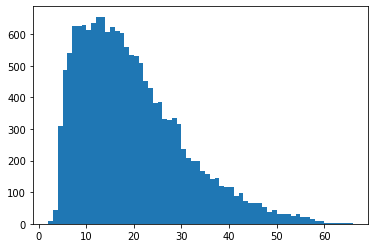

In [17]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [18]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
    return padded

In [20]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [21]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [22]:
# Preparing Labels

In [23]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

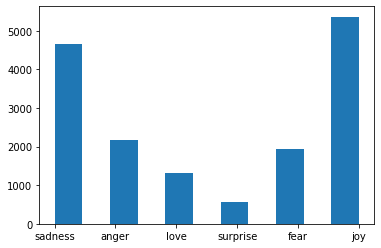

In [24]:
plt.hist(labels, bins = 11)
plt.show()

In [25]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [26]:
class_to_index

{'love': 0, 'sadness': 1, 'joy': 2, 'fear': 3, 'surprise': 4, 'anger': 5}

In [27]:
index_to_class

{0: 'love', 1: 'sadness', 2: 'joy', 3: 'fear', 4: 'surprise', 5: 'anger'}

In [28]:
name_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [29]:
train_labels = name_to_ids(labels)
print(train_labels[0])

1


In [30]:
# Creating The Model

In [31]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(
    
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Training The Model

In [34]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = name_to_ids(val_labels)

In [35]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [36]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 24s 41ms/step - loss: 1.2632 - accuracy: 0.5057 - val_loss: 0.7086 - val_accuracy: 0.7555
Epoch 2/20
500/500 [==============================] - 18s 37ms/step - loss: 0.5262 - accuracy: 0.8181 - val_loss: 0.5497 - val_accuracy: 0.8120
Epoch 3/20
500/500 [==============================] - 18s 37ms/step - loss: 0.3093 - accuracy: 0.8974 - val_loss: 0.4431 - val_accuracy: 0.8510
Epoch 4/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2042 - accuracy: 0.9344 - val_loss: 0.4169 - val_accuracy: 0.8635
Epoch 5/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1509 - accuracy: 0.9510 - val_loss: 0.4447 - val_accuracy: 0.8700
Epoch 6/20
500/500 [==============================] - 22s 45ms/step - loss: 0.1188 - accuracy: 0.9650 - val_loss: 0.4308 - val_accuracy: 0.8725
Epoch 7/20
500/500 [==============================] - 19s 39ms/step - loss: 0.0954 - accuracy: 0.9709 - val_loss: 0.4116 - val_accuracy:

In [37]:
# Evaluating The Model

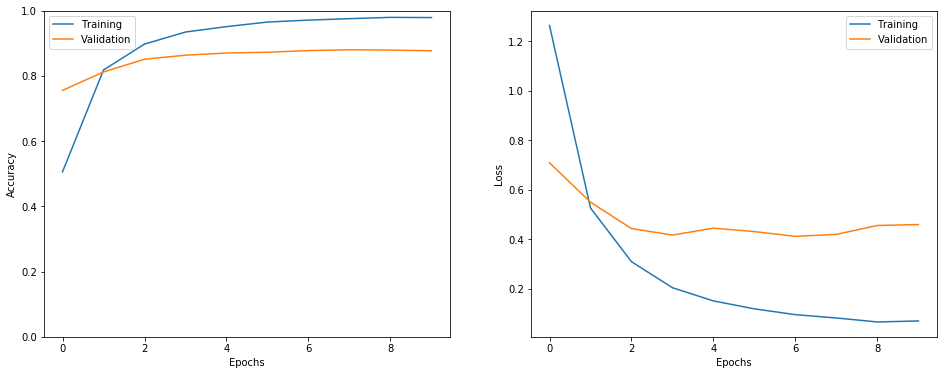

In [38]:
show_history(h)

In [39]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = name_to_ids(test_labels)

In [40]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 17ms/step - loss: 0.4420 - accuracy: 0.8775


In [41]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
Emotion: surprise
Predicted Emotion: surprise


In [42]:
preds = model.predict_classes(test_seq)

D:\Anaconda_2019\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


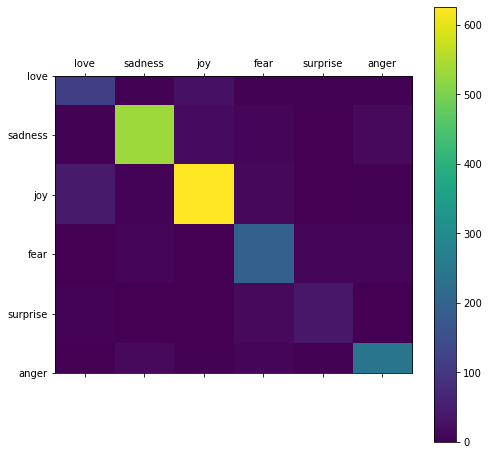

In [43]:
show_confusion_matrix(test_labels, preds, list(classes))